In [1]:
import pandas as pd
from glob import glob
import numpy as np
import tables as tb
from sklearn.cluster import DBSCAN
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
def get_files(run):
    folder = f'/analysis/{run}/hdf5/data/*h5'
    files = glob(folder)
    files.sort()
    return files

In [3]:
def read_run_data(files):
    dfs = []
    for fname in files:
        try:
            df = pd.read_hdf(fname, 'data')
            dfs.append(df)
        except:
            print("Error in file ", fname)
    df = pd.concat(dfs).reset_index(drop=True)
    return df

In [4]:
def get_evt_times(files):
    time_dfs = []

    for i, fname in enumerate(files):
        df_time = pd.read_hdf(fname, 'dateEvents')
        df_time['fileno'] = i
        time_dfs.append(df_time)
    df_times = pd.concat(time_dfs)
    df_times['date'] = pd.to_datetime(df_times.timestamp, unit='us')

    # Compute time difference between one event and the next
    df_times['time_diff'] = np.abs((df_times.timestamp/1e6).diff(periods=-1))
    df_times = df_times.fillna(0)
    return df_times

In [5]:
def compute_tcoarse_wrap_arounds(df):
    limits = df[df.tcoarse_diff < -30000].index
    first  = df.index[0]
    last   = df.index[-1]
    limits = np.concatenate([np.array([first]), limits.values, np.array([last])])
    return limits

In [6]:
def compute_tcoarse_nloops_per_event(df):
    limits = df.groupby('evt_number').apply(compute_tcoarse_wrap_arounds)
    
    nloops = np.zeros(df.shape[0], dtype='int32')

    for evt_limits in limits.values:
        for i in range(evt_limits.shape[0]-1):
            start = evt_limits[i]
            end   = evt_limits[i+1]

            nloops[start:end+1] = i
            
    return nloops    

In [7]:
def compute_extended_tcoarse(df):
    return df['tcoarse'] + df['nloops'] * 2**16

In [8]:
def compute_integration_window_size(df):
    df['intg_w'] = (df.ecoarse - (df.tcoarse % 2**10)).astype('int16')
    df.loc[df['intg_w'] < 0, 'intg_w'] += 2**10

In [9]:
def apply_qdc_correction(df, df_qdc):
    df = df.reset_index().merge(df_qdc[['channel_id', 'tac_id', 'qoffset', 'ibias']], on=['channel_id', 'tac_id'])
    df['charge_corrected'] = df.efine - (df.ibias*df.intg_w + df.qoffset)
    df.drop(columns=['qoffset', 'ibias'], inplace=True)
    df = df.sort_values('index').set_index('index')
    df.index.name = None
    return df

In [10]:
def apply_tdc_correction(df, df_tdc):
    df = df.reset_index().merge(df_tdc[['channel_id', 'tac_id', 'amplitude', 'offset']], on=['channel_id', 'tac_id'])
    df = df.sort_values('index').set_index('index')
    df.index.name = None
    
    period = 360
    df['tfine_corrected'] = (period/np.pi)*np.arctan(1/np.tan((np.pi/(-2*df.amplitude))*(df.tfine-df.offset)))
    df.loc[df['tfine_corrected'] < 0, 'tfine_corrected'] += period
    df = df.drop(columns=['amplitude', 'offset'])
    df['t'] = df.tcoarse - (360 - df.tfine_corrected) / 360
    return df

### Read file by chunks 

In [11]:
def process_daq_df(df, df_tdc, df_qdc):
    # Remove non-used columns
    df.drop(columns=['card_id', 'tofpet_id', 'wordtype_id'], inplace=True)
    
    # Add extended tcoarse
    df['tcoarse']          = df.tcoarse.astype(np.int32)
    df['tcoarse_diff']     = df.tcoarse.diff()
    df['nloops']           = compute_tcoarse_nloops_per_event(df)
    df['tcoarse_extended'] = compute_extended_tcoarse(df)
    df.drop(columns=['tcoarse_diff', 'nloops'], inplace=True)
    
    # TODO: Use corrected timestamp to compute integration window
    compute_integration_window_size(df)

    # Add row and column
    #df['x'] =  df.sensor_id // 10
    #df['y'] =  df.sensor_id  % 10
    
    df = apply_qdc_correction(df, df_qdc)
    df = apply_tdc_correction(df, df_tdc)
    
    df.drop(columns=['tac_id', 'ecoarse'], inplace=True)
    
    return df

In [12]:
def write_corrected_df_daq(fileout, df, append=False):
    table_name = 'data'
    table_evt_numbers = 'evts'
    mode = 'a' if append else 'w'
    store = pd.HDFStore(fileout, mode, complib=str("zlib"), complevel=4)
    if append:
        store.append(table_name, df, index=False, format='table', data_columns=None)
        store.append(table_evt_numbers, df['evt_number'], index=False, format='table', data_columns=['evt_number'])
    else:
        store.put(table_name, df, index=False, format='table', data_columns=None)
        store.append(table_evt_numbers, df['evt_number'], index=False, format='table', data_columns=['evt_number'])
    store.close()

In [13]:
def compute_file_chunks_indices(filein):
    with tb.open_file(filein) as h5in:
        evt_numbers = h5in.root.data.cols.evt_number[:]
        evt_diffs  = np.diff(evt_numbers)
        evt_limits = np.where(evt_diffs)[0]
        
        # Find borders that keep ~chunk_size rows per chunk
        chunk_size   = 500000
        chunk_diffs  = np.diff(evt_limits // chunk_size)
        chunk_limits = np.where(chunk_diffs)[0]
        
        chunks = np.concatenate([np.array([0]),
                         evt_limits[chunk_limits],
                         np.array([evt_numbers.shape[0]])])
        return chunks

#### Compute clusters

In [14]:
def compute_clusters(df):
    values = df.tcoarse_extended.values
    values = values.reshape(values.shape[0],1)

    clusters = DBSCAN(eps=10, min_samples=2).fit(values)
    return clusters.labels_

In [15]:
def compute_evt_number_combined_with_cluster_id(df):
    df_clusters = df.groupby('evt_number').apply(compute_clusters)
    df['cluster'] = np.concatenate(df_clusters.values)
    df.loc[df[df.cluster != -1].index, 'cluster'] = df.evt_number * 20000 + df.cluster

In [16]:
def process_daq_file(filein, fileout):
    chunks = compute_file_chunks_indices(filein)
    nchunks = chunks.shape[0]
    
    for i in range(nchunks-1):
        print("{}/{}".format(i, nchunks-2))
        start = chunks[i]
        end   = chunks[i+1]

        df = pd.read_hdf(filein, 'data', start=start, stop=end+1)

        df_corrected = process_daq_df(df, df_tdc, df_qdc)
        compute_evt_number_combined_with_cluster_id(df_corrected)
        write_corrected_df_daq(fileout, df_corrected, i>0)

# Process file

In [17]:
# QDC correction
df_qdc = pd.read_hdf('efine_cal_asic0.h5')

In [18]:
# TDC correction
df_tdc = pd.read_hdf('asic0_tfine_cal.h5')

In [19]:
run_number = 10847 # 49V, lsb 57, Na-22

In [20]:
files = get_files(run_number)
files

['/analysis/10847/hdf5/data/run_10847_0000_trigger1_waveforms.h5',
 '/analysis/10847/hdf5/data/run_10847_0001_trigger1_waveforms.h5',
 '/analysis/10847/hdf5/data/run_10847_0002_trigger1_waveforms.h5',
 '/analysis/10847/hdf5/data/run_10847_0003_trigger1_waveforms.h5',
 '/analysis/10847/hdf5/data/run_10847_0004_trigger1_waveforms.h5',
 '/analysis/10847/hdf5/data/run_10847_0005_trigger1_waveforms.h5',
 '/analysis/10847/hdf5/data/run_10847_0006_trigger1_waveforms.h5',
 '/analysis/10847/hdf5/data/run_10847_0007_trigger1_waveforms.h5']

In [21]:
outfile = 'run_10847_0000.h5'

In [22]:
process_daq_file(files[0], outfile)

0/112
1/112
2/112
3/112
4/112
5/112
6/112
7/112
8/112
9/112
10/112
11/112
12/112
13/112
14/112
15/112
16/112
17/112
18/112
19/112
20/112
21/112
22/112
23/112
24/112
25/112
26/112
27/112
28/112
29/112
30/112
31/112
32/112
33/112
34/112
35/112
36/112
37/112
38/112
39/112
40/112
41/112
42/112
43/112
44/112
45/112
46/112
47/112
48/112
49/112
50/112
51/112
52/112
53/112
54/112
55/112
56/112
57/112
58/112
59/112
60/112
61/112
62/112
63/112
64/112
65/112
66/112
67/112
68/112
69/112
70/112
71/112
72/112
73/112
74/112
75/112
76/112
77/112
78/112
79/112
80/112
81/112
82/112
83/112
84/112
85/112
86/112
87/112
88/112
89/112
90/112
91/112
92/112
93/112
94/112
95/112
96/112
97/112
98/112
99/112
100/112
101/112
102/112
103/112
104/112
105/112
106/112
107/112
108/112
109/112
110/112
111/112
112/112


In [23]:
df = pd.read_hdf(outfile, '/data')

In [24]:
df

,evt_number,channel_id,sensor_id,tcoarse,tfine,efine,tcoarse_extended,intg_w,charge_corrected,tfine_corrected,t,cluster
0,1,9,36,49594,232,238,49594,77,-9.098730,316.293818,49593.878594,20000
1,1,31,44,49594,226,225,49594,77,-6.952430,4.100319,49593.011390,20000
2,1,25,43,49595,240,148,49595,77,-15.179913,291.647669,49594.810132,20000
3,1,52,64,49594,245,233,49594,77,-2.747344,285.035161,49593.791764,20000
4,1,43,65,49594,274,145,49594,77,-17.296446,262.602472,49593.729451,20000
...,...,...,...,...,...,...,...,...,...,...,...,...
154926,17861,58,87,27542,271,110,1076118,78,-29.004578,203.660398,27541.565723,357220411
154927,17861,30,23,27540,388,209,1076116,77,-2.720294,37.418027,27539.103939,357220411
154928,17861,27,47,28771,260,227,1077347,77,-1.923844,260.009987,28770.722250,-1
154929,17861,56,77,27540,235,647,1076116,78,254.813956,315.513649,27539.876427,357220411


# Rate estimation

In [25]:
def compute_file_chunks_indices_pandas(filein):
    store = pd.HDFStore(outfile, 'r')
    evt_numbers = store.select('/evts').values
    store.close()

    evt_diffs  = np.diff(evt_numbers)
    evt_limits = np.where(evt_diffs)[0]

    # Find borders that keep ~chunk_size rows per chunk
    chunk_size   = 500000
    chunk_diffs  = np.diff(evt_limits // chunk_size)
    chunk_limits = np.where(chunk_diffs)[0]

    chunks = np.concatenate([np.array([0]),
                     evt_limits[chunk_limits],
                     np.array([evt_numbers.shape[0]])])
    return chunks

In [47]:
chunks = compute_file_chunks_indices_pandas(outfile)

In [27]:
clusters = []

chunks = compute_file_chunks_indices_pandas(outfile)
nchunks = chunks.shape[0]

for i in range(nchunks-1):
    print("{}/{}".format(i, nchunks-2))
    start = chunks[i]
    end   = chunks[i+1]

    df = pd.read_hdf(outfile, 'data', start=start, stop=end+1)
    clusters.append(df.cluster.values)

clusters = np.concatenate(clusters)

0/112
1/112
2/112
3/112
4/112
5/112
6/112
7/112
8/112
9/112
10/112
11/112
12/112
13/112
14/112
15/112
16/112
17/112
18/112
19/112
20/112
21/112
22/112
23/112
24/112
25/112
26/112
27/112
28/112
29/112
30/112
31/112
32/112
33/112
34/112
35/112
36/112
37/112
38/112
39/112
40/112
41/112
42/112
43/112
44/112
45/112
46/112
47/112
48/112
49/112
50/112
51/112
52/112
53/112
54/112
55/112
56/112
57/112
58/112
59/112
60/112
61/112
62/112
63/112
64/112
65/112
66/112
67/112
68/112
69/112
70/112
71/112
72/112
73/112
74/112
75/112
76/112
77/112
78/112
79/112
80/112
81/112
82/112
83/112
84/112
85/112
86/112
87/112
88/112
89/112
90/112
91/112
92/112
93/112
94/112
95/112
96/112
97/112
98/112
99/112
100/112
101/112
102/112
103/112
104/112
105/112
106/112
107/112
108/112
109/112
110/112
111/112
112/112


In [31]:
evts = np.unique(clusters).shape[0]
evts

5539448

In [29]:
df_times = get_evt_times([files[0]])

In [30]:
duration = df_times.timestamp.values.ptp() / 1e6
duration 

61.709986

In [32]:
rate = evts / duration
rate

89765.82817568618

In [51]:
clusters

array([    20000,     20000,     20000, ...,        -1, 357220411,
              -1])

In [35]:
_, counts = np.unique(clusters, return_counts=True)

Text(0.5, 1.0, 'Sensors per real evt')

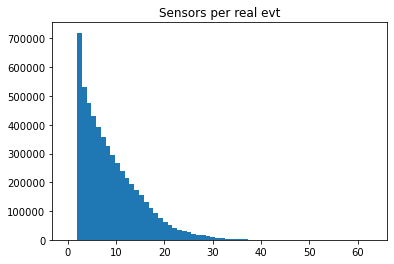

In [45]:
plt.hist(counts, bins=64, range=[0, 63]);
plt.title("Sensors per real evt")

Text(0.5, 1.0, 'Sensors per real evt')

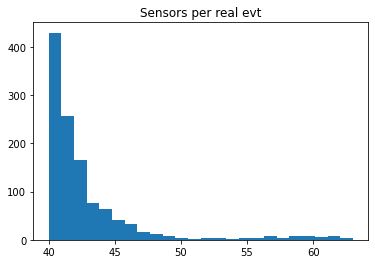

In [52]:
plt.hist(counts, bins=24, range=[40, 63]);
plt.title("Sensors per real evt")

In [46]:
counts[0]

8134053